In [1]:
import pandas
import pyreadr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
def transaction_v3_Polygon():
    transaction = pyreadr.read_r("/data/IDEA_DeFi_Research/Data/Lending_Protocols/Aave/V3/Polygon/transactions.rds")
    df = transaction[None]
    df['DateTime'] = df['timestamp'].transform(lambda x: datetime.fromtimestamp(x))
    df.head()
    # We are going to make a super basic linear model to try and predict how the AAVE token's price changes each day.
    # This script will engineer one feature to use for this predictive task: dailyTransactionCount.

    # To do this, we group the data by the date portion of the DateTime object, 
    # and then simply count how many transactions are in each group
    dailyTransactionCount = df.groupby([df['DateTime'].dt.date]).count()
    
    # Add the liquidations type to the dataframe
    liquidations = df[df['type'] == "liquidation"]
    liquidations = liquidations.filter(items = ['DateTime', 'type', 'user', 'principalAmountUSD', 'collateralAmountUSD'], axis = 'columns')
    liquidations = liquidations.groupby([liquidations['DateTime'].dt.date]).sum()
    # print(liquidations)
    
    # add borrow type to the dataframe
    borrows = df[df['type'] == "borrow"]
    dailyBorrowsAmountsUSD = borrows.groupby([borrows['DateTime'].dt.date]).sum()
    dailyBorrowsAmountsUSD['amountBorrowsUSD'] = dailyBorrowsAmountsUSD['amountUSD']
    dailyBorrowsAmountsUSD = dailyBorrowsAmountsUSD.filter(items = ['DateTime', 'amountBorrowsUSD'], axis = 'columns')
    # print(dailyBorrowsAmountsUSD)
    
    # add deposit type to the dataframe
    deposits = df[df['type'] == "deposit"]
    dailyDepositsAmountsUSD = deposits.groupby([deposits['DateTime'].dt.date]).sum()
    dailyDepositsAmountsUSD['amountDepositsUSD'] = dailyDepositsAmountsUSD['amountUSD']
    dailyDepositsAmountsUSD = dailyDepositsAmountsUSD.filter(items = ['DateTime', 'amountDepositsUSD'], axis = 'columns')
    # print(dailyDepositsAmountsUSD)
    
    # add repay type to the dataframe
    repays = df[df['type'] == "repay"]
    dailyRepaysAmountsUSD = repays.groupby([repays['DateTime'].dt.date]).sum()
    dailyRepaysAmountsUSD['amountRepaysUSD'] = dailyRepaysAmountsUSD['amountUSD']
    dailyRepaysAmountsUSD = dailyRepaysAmountsUSD.filter(items = ['DateTime', 'amountRepaysUSD'], axis = 'columns')
    # print(dailyRepaysAmountsUSD)
    
    # add withdraw type to the dataframe
    withdraws = df[df['type'] == "withdraw"]
    dailyWithdrawsAmountsUSD = withdraws.groupby([withdraws['DateTime'].dt.date]).sum()
    dailyWithdrawsAmountsUSD['amountWithdrawsUSD'] = dailyWithdrawsAmountsUSD['amountUSD']
    dailyWithdrawsAmountsUSD = dailyWithdrawsAmountsUSD.filter(items = ['DateTime', 'amountWithdrawsUSD'], axis = 'columns')
    # print(dailyWithdrawsAmountsUSD)
    
    dailyTransactionCount = dailyTransactionCount[['id']]
    dailyTransactionCount.rename(columns={"id": "transactionCount"}, inplace = True)
    # print(dailyTransactionCount)
    
    # We load the minutely Aave price data here:
    aavePrices = pandas.read_csv('/data/IDEA_DeFi_Research/Data/Coin_Prices/Minutely/aavePrices.csv')
    # And here, since we want to predict daily prices, we create a new features which is the mean daily price.
    aavePrices['DateTime'] = aavePrices['timestamp'].transform(lambda x: datetime.fromtimestamp(x))
    dailyMeanPrices = aavePrices.groupby([df['DateTime'].dt.date]).mean()
    dailyMeanPrices = dailyMeanPrices[['priceUSD']]
    # print(dailyMeanPrices)
    
    # feature engineering, merge deposit, repay, withdraw, borrow, liquidation in dailyTransactionCount
    dailyTransactionCount = dailyTransactionCount.merge(dailyMeanPrices, how = "left", on = "DateTime")
    dailyTransactionCount = dailyTransactionCount.merge(dailyBorrowsAmountsUSD, how = "left", on = "DateTime")
    dailyTransactionCount = dailyTransactionCount.merge(dailyDepositsAmountsUSD, how = "left", on = "DateTime")
    dailyTransactionCount = dailyTransactionCount.merge(dailyRepaysAmountsUSD, how = "left", on = "DateTime")
    dailyTransactionCount = dailyTransactionCount.merge(dailyWithdrawsAmountsUSD, how = "left", on = "DateTime")
    dailyTransactionCount = dailyTransactionCount.merge(liquidations, how = "left", on = "DateTime")
    
    # replace all NaN data to 0
    dailyTransactionCount.fillna(0, inplace=True)
    print(dailyTransactionCount)
    
    return dailyTransactionCount

In [3]:
def data_split(data_set):
    from sklearn.model_selection import TimeSeriesSplit
    # We want to use the transactionCount to predict the next day's price. To do this, we "lead" the priceUSD
    # column so in a given row, the transaction count is aligned with the next day's price.
    data_set['priceUSD_lead_1'] = data_set['priceUSD'].shift(-1)
    # We need to drop NA values. One NA value is introduced through this "lead" on the last day in the dataset.
    data_set.dropna(inplace=True)
    # In practice, it is better to predict daily percent price changes rather than predicting literal prices, so we compute the daily
    # percent change here by subtraction tomorrow's price from today's and dividing by today's price.
    data_set['dailyPercentChange'] = (data_set['priceUSD_lead_1'] - data_set['priceUSD']) / data_set['priceUSD']
    # We want to predict the direction of the daily percent change, so we create a new feature which is the sign of the daily percent change.
    data_set['directionOfDailyChange'] = np.sign(data_set['dailyPercentChange'])
    # print(data_set)
    tss = TimeSeriesSplit(n_splits = 3)
    X = data_set.drop(labels=['priceUSD_lead_1', 'dailyPercentChange', 'directionOfDailyChange'],axis=1)
    y = data_set['directionOfDailyChange']
    for train_index, test_index in tss.split(data_set):
        feature_train, feature_test = X.iloc[train_index, :], X.iloc[test_index,:]
        target_train, target_test = y.iloc[train_index], y.iloc[test_index]
    return [feature_train, feature_test, target_train, target_test]

In [4]:
def plot_ground_truth(predictions, target_test_vals):
    # We plot the ground-truth values in blue and the predicted values in red:
    plt.plot(target_test_vals, color = "lightblue")
    plt.plot(predictions, color = "lightpink")

In [5]:
def plot_difference(predictions, y_test_vals):
    # We plot the difference between our model's predictions and the actual values:
    plt.plot(y_test_vals - predictions)

In [6]:
machine_learning_model_record = dict()

In [7]:
def logistic_regression_model(feature_train, feature_test, target_train, target_test):
    from sklearn.linear_model import LogisticRegression
    estimator = LogisticRegression(C = 1.0, penalty = "l2", solver = "liblinear", fit_intercept=True, max_iter=1000)
    fit = estimator.fit(feature_train, target_train)
    # We compute the predictions for the feature_test features:
    predictions = fit.predict(feature_test)
    # The line below just computes the average accuracy of our predictions:
    np.linalg.norm(predictions - target_test) / len(target_test)
    target_test_vals = list()
    for data in target_test:
        target_test_vals.append(data)
    # model evaluation
    target_predict = estimator.predict(feature_test)
    print("-------------------- logistic regression --------------------\n")
    print("The target_predict is:\n", target_predict)
    print("Compare predicted results with actual values:\n", target_predict == target_test)
    accuracy = estimator.score(feature_test, target_test) * 100
    print("Accuracy:\n{0:.2f}%".format(accuracy))
    return predictions, target_test_vals, accuracy

In [8]:
dailyTransactionCount_v3_Polygon = transaction_v3_Polygon()
feature_train, feature_test, target_train, target_test = data_split(dailyTransactionCount_v3_Polygon)
predictions, target_test_vals, accuracy = logistic_regression_model(feature_train, feature_test, target_train, target_test)
# make record for the accuracy
machine_learning_model_record["logistic_regression"] = accuracy

            transactionCount    priceUSD  amountBorrowsUSD  amountDepositsUSD  \
DateTime                                                                        
2022-03-12                 6  117.727863      0.000000e+00       3.399416e+08   
2022-03-13                 2    0.000000      0.000000e+00       2.403706e+08   
2022-03-14                 5   76.083365      9.998918e+07       3.991012e+08   
2022-03-16              1513  105.123358      6.089499e+13       2.545663e+14   
2022-03-17              2345  105.969502      1.191550e+14       5.118132e+14   
...                      ...         ...               ...                ...   
2023-09-07             11530  118.532923      1.542727e+15       5.327923e+14   
2023-09-08             10758  122.033832      1.276946e+15       4.281255e+14   
2023-09-09              9009  128.070226      1.194785e+15       2.288192e+14   
2023-09-10             11073  120.957283      1.691685e+15       5.664417e+14   
2023-09-11              5784

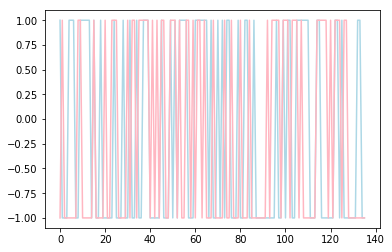

In [9]:
plot_ground_truth(predictions, target_test_vals)

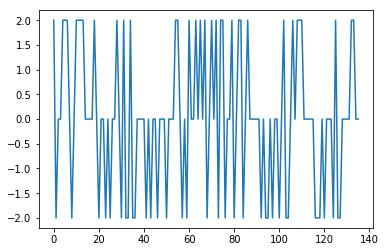

In [10]:
plot_difference(predictions, target_test_vals)

In [11]:
def knn_model_gridSearchCV(feature_train, feature_test, target_train, target_test):
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.preprocessing import StandardScaler
    transfer = StandardScaler()
    # train data standardization
    feature_train = transfer.fit_transform(feature_train)
    feature_test = transfer.transform(feature_test)
    estimator = KNeighborsClassifier(n_neighbors=3, weights="uniform", algorithm="auto", leaf_size=30, p=2, metric="minkowski", metric_params=None, n_jobs=None)
    # KNN model optimization
    estimator = KNeighborsClassifier()
    parameters_testcase = {"n_neighbors": [3, 5, 7, 9, 11, 13]}
    estimator = GridSearchCV(estimator, parameters_testcase, cv=3)
    estimator.fit(feature_train, target_train)
    # We compute the predictions for the feature_test features:
    predictions = estimator.predict(feature_test)
    # The line below just computes the average accuracy of our predictions:
    np.linalg.norm(predictions - target_test) / len(target_test)
    target_test_vals = list()
    for data in target_test:
        target_test_vals.append(data)
    # model evaluation
    target_predict = estimator.predict(feature_test)
    print("-------------------- knn with gridSearchCV --------------------\n")
    print("The target_predict is:\n", target_predict)
    print("Compare predicted results with actual values:\n", target_predict == target_test)
    accuracy = estimator.score(feature_test, target_test) * 100
    print("Accuracy:\n{0:.2f}%".format(accuracy))
    return predictions, target_test_vals, accuracy

In [12]:
dailyTransactionCount_v3_Polygon = transaction_v3_Polygon()
feature_train, feature_test, target_train, target_test = data_split(dailyTransactionCount_v3_Polygon)
predictions, target_test_vals, accuracy = knn_model_gridSearchCV(feature_train, feature_test, target_train, target_test)
# make record for the accuracy
machine_learning_model_record["knn_gridSearch"] = accuracy

            transactionCount    priceUSD  amountBorrowsUSD  amountDepositsUSD  \
DateTime                                                                        
2022-03-12                 6  117.727863      0.000000e+00       3.399416e+08   
2022-03-13                 2    0.000000      0.000000e+00       2.403706e+08   
2022-03-14                 5   76.083365      9.998918e+07       3.991012e+08   
2022-03-16              1513  105.123358      6.089499e+13       2.545663e+14   
2022-03-17              2345  105.969502      1.191550e+14       5.118132e+14   
...                      ...         ...               ...                ...   
2023-09-07             11530  118.532923      1.542727e+15       5.327923e+14   
2023-09-08             10758  122.033832      1.276946e+15       4.281255e+14   
2023-09-09              9009  128.070226      1.194785e+15       2.288192e+14   
2023-09-10             11073  120.957283      1.691685e+15       5.664417e+14   
2023-09-11              5784

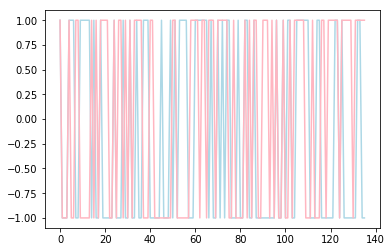

In [13]:
plot_ground_truth(predictions, target_test_vals)

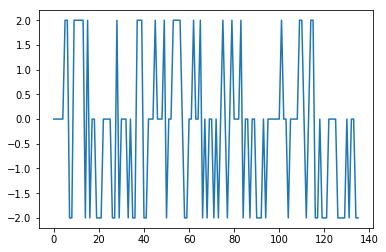

In [14]:
plot_difference(predictions, target_test_vals)

In [15]:
def multinomialNB_model(feature_train, feature_test, target_train, target_test):
    from sklearn.naive_bayes import MultinomialNB
    estimator = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
    fit = estimator.fit(feature_train, target_train)
    # We compute the predictions for the feature_test features:
    predictions = fit.predict(feature_test)
    # The line below just computes the average accuracy of our predictions:
    np.linalg.norm(predictions - target_test) / len(target_test)
    target_test_vals = list()
    for data in target_test:
        target_test_vals.append(data)
    # model evaluation
    target_predict = estimator.predict(feature_test)
    print("-------------------- naive bayes --------------------\n")
    print("The target_predict is:\n", target_predict)
    print("Compare predicted results with actual values:\n", target_predict == target_test)
    accuracy = estimator.score(feature_test, target_test) * 100
    print("Accuracy:\n{0:.2f}%".format(accuracy))
    return predictions, target_test_vals, accuracy

In [16]:
dailyTransactionCount_v3_Polygon = transaction_v3_Polygon()
feature_train, feature_test, target_train, target_test = data_split(dailyTransactionCount_v3_Polygon)
predictions, target_test_vals, accuracy = multinomialNB_model(feature_train, feature_test, target_train, target_test)
# make record for the accuracy
machine_learning_model_record["naive_bayes"] = accuracy

            transactionCount    priceUSD  amountBorrowsUSD  amountDepositsUSD  \
DateTime                                                                        
2022-03-12                 6  117.727863      0.000000e+00       3.399416e+08   
2022-03-13                 2    0.000000      0.000000e+00       2.403706e+08   
2022-03-14                 5   76.083365      9.998918e+07       3.991012e+08   
2022-03-16              1513  105.123358      6.089499e+13       2.545663e+14   
2022-03-17              2345  105.969502      1.191550e+14       5.118132e+14   
...                      ...         ...               ...                ...   
2023-09-07             11530  118.532923      1.542727e+15       5.327923e+14   
2023-09-08             10758  122.033832      1.276946e+15       4.281255e+14   
2023-09-09              9009  128.070226      1.194785e+15       2.288192e+14   
2023-09-10             11073  120.957283      1.691685e+15       5.664417e+14   
2023-09-11              5784

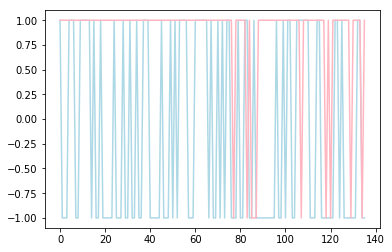

In [17]:
plot_ground_truth(predictions, target_test_vals)

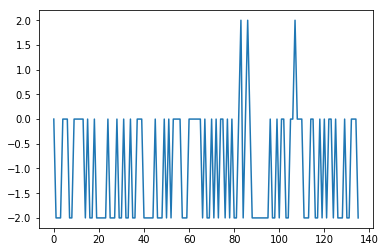

In [18]:
plot_difference(predictions, target_test_vals)

In [19]:
def decision_tree_model(feature_train, feature_test, target_train, target_test):
    from sklearn.tree import DecisionTreeClassifier
    estimator = DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0)
    fit = estimator.fit(feature_train, target_train)
    # We compute the predictions for the feature_test features:
    predictions = fit.predict(feature_test)
    # The line below just computes the average accuracy of our predictions:
    np.linalg.norm(predictions - target_test) / len(target_test)
    target_test_vals = list()
    for data in target_test:
        target_test_vals.append(data)
    # model evaluation
    target_predict = estimator.predict(feature_test)
    print("-------------------- decision tree --------------------\n")
    print("The target_predict is:\n", target_predict)
    print("Compare predicted results with actual values:\n", target_predict == target_test)
    accuracy = estimator.score(feature_test, target_test) * 100
    print("Accuracy:\n{0:.2f}%".format(accuracy))
    return predictions, target_test_vals, accuracy

In [20]:
dailyTransactionCount_v3_Polygon = transaction_v3_Polygon()
feature_train, feature_test, target_train, target_test = data_split(dailyTransactionCount_v3_Polygon)
predictions, target_test_vals, accuracy = decision_tree_model(feature_train, feature_test, target_train, target_test)
# make record for the accuracy
machine_learning_model_record["decision_tree"] = accuracy

            transactionCount    priceUSD  amountBorrowsUSD  amountDepositsUSD  \
DateTime                                                                        
2022-03-12                 6  117.727863      0.000000e+00       3.399416e+08   
2022-03-13                 2    0.000000      0.000000e+00       2.403706e+08   
2022-03-14                 5   76.083365      9.998918e+07       3.991012e+08   
2022-03-16              1513  105.123358      6.089499e+13       2.545663e+14   
2022-03-17              2345  105.969502      1.191550e+14       5.118132e+14   
...                      ...         ...               ...                ...   
2023-09-07             11530  118.532923      1.542727e+15       5.327923e+14   
2023-09-08             10758  122.033832      1.276946e+15       4.281255e+14   
2023-09-09              9009  128.070226      1.194785e+15       2.288192e+14   
2023-09-10             11073  120.957283      1.691685e+15       5.664417e+14   
2023-09-11              5784

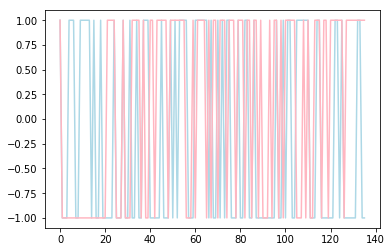

In [21]:
plot_ground_truth(predictions, target_test_vals)

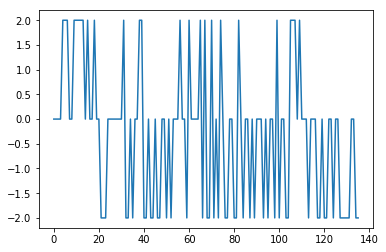

In [22]:
plot_difference(predictions, target_test_vals)

In [23]:
def random_forest_model_gridSearchCV(feature_train, feature_test, target_train, target_test):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import GridSearchCV
    estimator = RandomForestClassifier()
    param_dict = {"n_estimators": [120,200,300,500,800,1200], "max_depth": [5,8,15,25,30]}
    estimator = GridSearchCV(estimator, param_grid=param_dict, cv=3)
    estimator.fit(feature_train, target_train)
    # We compute the predictions for the feature_test features:
    predictions = estimator.predict(feature_test)
    # The line below just computes the average accuracy of our predictions:
    np.linalg.norm(predictions - target_test) / len(target_test)
    target_test_vals = list()
    for data in target_test:
        target_test_vals.append(data)
    # model evaluation
    target_predict = estimator.predict(feature_test)
    print("-------------------- random forest --------------------\n")
    print("The target_predict is:\n", target_predict)
    print("Compare predicted results with actual values:\n", target_predict == target_test)
    accuracy = estimator.score(feature_test, target_test) * 100
    print("Accuracy:\n{0:.2f}%".format(accuracy))
    return predictions, target_test_vals, accuracy

In [24]:
dailyTransactionCount_v3_Polygon = transaction_v3_Polygon()
feature_train, feature_test, target_train, target_test = data_split(dailyTransactionCount_v3_Polygon)
predictions, target_test_vals, accuracy = random_forest_model_gridSearchCV(feature_train, feature_test, target_train, target_test)
# make record for the accuracy
machine_learning_model_record["random_forest_gridSearchCV"] = accuracy

            transactionCount    priceUSD  amountBorrowsUSD  amountDepositsUSD  \
DateTime                                                                        
2022-03-12                 6  117.727863      0.000000e+00       3.399416e+08   
2022-03-13                 2    0.000000      0.000000e+00       2.403706e+08   
2022-03-14                 5   76.083365      9.998918e+07       3.991012e+08   
2022-03-16              1513  105.123358      6.089499e+13       2.545663e+14   
2022-03-17              2345  105.969502      1.191550e+14       5.118132e+14   
...                      ...         ...               ...                ...   
2023-09-07             11530  118.532923      1.542727e+15       5.327923e+14   
2023-09-08             10758  122.033832      1.276946e+15       4.281255e+14   
2023-09-09              9009  128.070226      1.194785e+15       2.288192e+14   
2023-09-10             11073  120.957283      1.691685e+15       5.664417e+14   
2023-09-11              5784

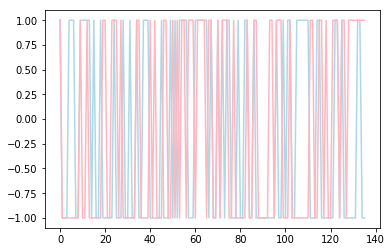

In [25]:
plot_ground_truth(predictions, target_test_vals)

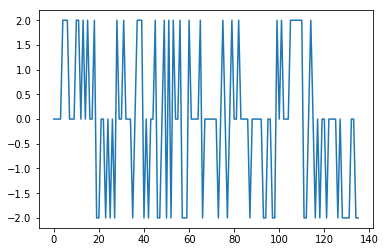

In [26]:
plot_difference(predictions, target_test_vals)

In [27]:
# model accuracy record
for i in machine_learning_model_record.keys():
    print("-" * 60)
    print("The accuracy of model: {} | {:.2f}%\n".format(i, machine_learning_model_record.get(i)))

------------------------------------------------------------
The accuracy of model: logistic_regression | 49.26%

------------------------------------------------------------
The accuracy of model: knn_gridSearch | 47.79%

------------------------------------------------------------
The accuracy of model: naive_bayes | 44.85%

------------------------------------------------------------
The accuracy of model: decision_tree | 47.79%

------------------------------------------------------------
The accuracy of model: random_forest_gridSearchCV | 50.74%

